# Detection and Classification of Military Planes: A Comparative Study of CNN, YOLO, Faster R-CNN, RetinaNet, and EfficientDet


---

In the midst of the ongoing war in Ukraine, the ability to accurately detect and classify military aircraft is of critical importance for surveillance, defense, and strategic planning. This capability can significantly contribute to national security and defense efforts.

Traditionally, image recognition tasks have relied on simple Convolutional Neural Networks (CNNs) for their relatively straightforward architecture and ease of implementation. However, with the availability of more complex models such as YOLO (You Only Look Once), Faster R-CNN, RetinaNet, and EfficientDet, the potential for higher accuracy and faster detection speeds has increased.

This project seeks to explore and compare the performance of these advanced models against a simple CNN baseline for the task of military aircraft detection and classification. By conducting this comparative study, I aim to identify the most suitable model for practical applications in military contexts.

I have decided to use a Military Aircraft Recognition dataset from the kaggle.com. This dataset include 3842 images, 20 types, and 22341 instances annotated with horizontal bounding boxes and oriented bounding boxes.

In order to simplify work I have downloaded all the dataset into my git repository. Lets start by importing our project code and data from the git repository:


In [19]:
# Clone the repository
!git clone https://github.com/AndriyDragan/HawkEye.git

# Install and import YOLOv5
!pip install -U ultralytics

# Data analysys and preparation

Now lets do some import of the dependecies and look at our data:

Number of samples: 3842
Image shape:       (800, 800, 3)


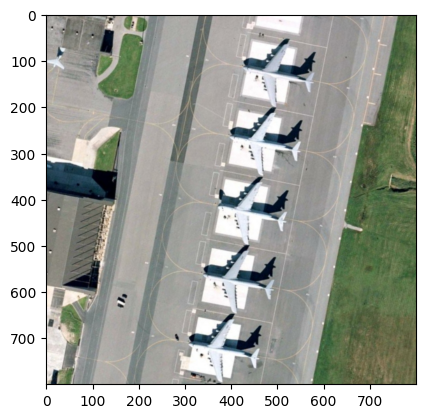

In [39]:
import os
import gc
import itertools
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import Counter, defaultdict
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch
from torch.utils.data import Dataset, DataLoader
import random
from tqdm.notebook import tqdm
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms as T
from ultralytics import YOLO

# lets use a fixed seed for the result consistency
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

data_dir = 'HawkEye/Data'

imfiles = os.listdir(os.path.join(data_dir, 'Images'))
imfiles = [os.path.join(data_dir, 'Images', f) for f in imfiles if os.path.splitext(f)[-1] == '.jpg']

def imread(filename):
    return cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)

sample = random.choice(imfiles)
image = imread(sample)
rows, cols, channels = image.shape

plt.imshow(image)
print('Number of samples:', len(imfiles))
print('Image shape:      ', image.shape)

In order to verify if our images have same size I will iterate all of them and clasify by shape:

In [21]:
# Dictionary to store the count of images for each shape
image_shapes = defaultdict(int)

for imfile in tqdm(imfiles):
    image = cv2.imread(imfile)
    if image is not None:
        shape = image.shape
        image_shapes[shape] += 1

# Iterate over all images and collect information about their shapes
for shape, count in image_shapes.items():
    print(f'Shape: {shape}, Count: {count}')

  0%|          | 0/3842 [00:00<?, ?it/s]

Shape: (867, 854, 3), Count: 1
Shape: (800, 800, 3), Count: 3167
Shape: (833, 836, 3), Count: 1
Shape: (887, 842, 3), Count: 1
Shape: (635, 742, 3), Count: 1
Shape: (837, 802, 3), Count: 1
Shape: (847, 772, 3), Count: 1
Shape: (751, 751, 3), Count: 7
Shape: (844, 865, 3), Count: 1
Shape: (624, 821, 3), Count: 1
Shape: (737, 737, 3), Count: 3
Shape: (817, 837, 3), Count: 1
Shape: (738, 834, 3), Count: 1
Shape: (864, 826, 3), Count: 1
Shape: (638, 1055, 3), Count: 1
Shape: (757, 742, 3), Count: 1
Shape: (723, 877, 3), Count: 1
Shape: (747, 1035, 3), Count: 1
Shape: (784, 924, 3), Count: 1
Shape: (720, 938, 3), Count: 1
Shape: (747, 747, 3), Count: 7
Shape: (786, 773, 3), Count: 1
Shape: (661, 767, 3), Count: 1
Shape: (673, 816, 3), Count: 1
Shape: (735, 735, 3), Count: 6
Shape: (752, 752, 3), Count: 3
Shape: (628, 858, 3), Count: 1
Shape: (787, 817, 3), Count: 1
Shape: (822, 838, 3), Count: 1
Shape: (796, 796, 3), Count: 1
Shape: (750, 750, 3), Count: 11
Shape: (726, 817, 3), Count: 1
Sh

As we can see there is a big veriety of the image shapes yet the main claster is Shape: (800, 800, 3), Count: 3167. This will be the base of our dataset:

In [22]:
# Function to read annotations
def read_annotations(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    annotations = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        annotations.append((name, (xmin, ymin, xmax, ymax)))
    return annotations

def read_data(file_names, data_dir):
    data = []
    labels = []
    dims = []

    for file_name in file_names:
        img_path = os.path.join(data_dir, 'Images', file_name + '.jpg')
        xml_path = os.path.join(data_dir, 'Labels', 'Horizontal Bounding Boxes', file_name + '.xml')
        img = Image.open(img_path)

        if img.size != (800, 800):
            continue

        annotations = read_annotations(xml_path)

        for annot in annotations:
            width = abs(annot[1][0] - annot[1][2])
            height = abs(annot[1][1] - annot[1][3])
            dims.append((width, height))
            labels.append(annot[0])

        data.append((img_path, xml_path, (width, height)))

    return data, labels, dims

file_names = [f.split('.')[0] for f in os.listdir(os.path.join(data_dir, 'Images'))]
data, labels, dims = read_data(file_names, data_dir)

Lets display some more of the random samples from our dataset, already with proper annotations:

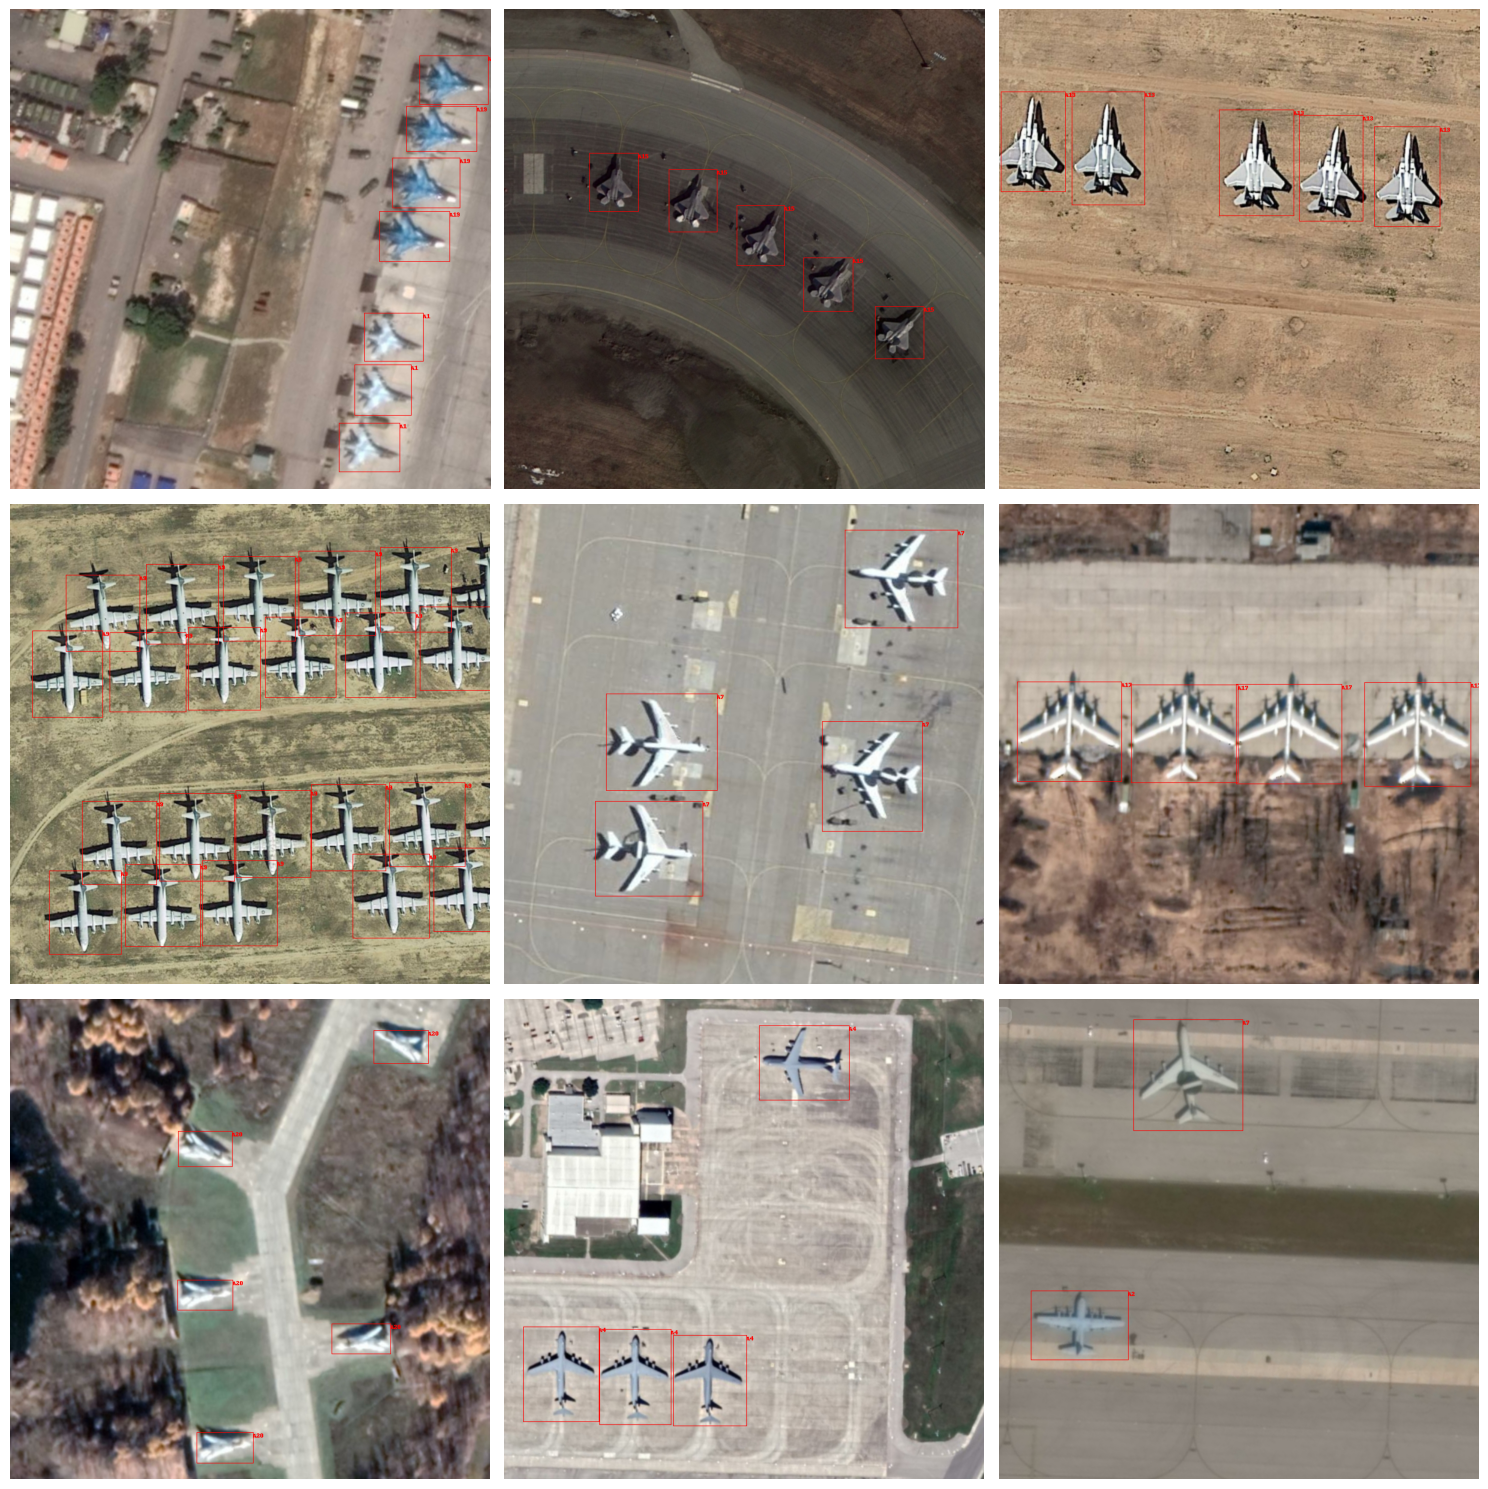

In [23]:
# Display random samples
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for ax in axes:
    idx = np.random.randint(0, len(data) - 1)
    img_path, xml_path, _ = data[idx]
    img = Image.open(img_path)
    annotations = read_annotations(xml_path)
    draw = ImageDraw.Draw(img)

    for obj in annotations:
        label, (xmin, ymin, xmax, ymax) = obj
        draw.rectangle([xmin, ymin, xmax, ymax], outline='red')
        font_size = 20
        draw.text((xmax, ymin), label, fill='red')

    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

I would like to visualise some additional properties of the dataset we will work with:

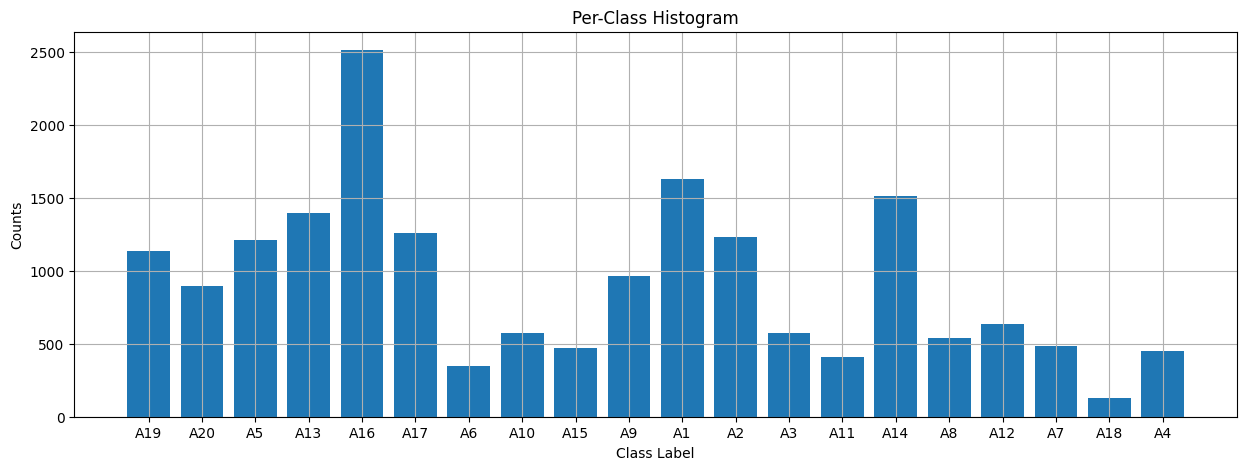

In [24]:
# Compute and plot the per-class histogram
hist = Counter(labels)
plt.figure(figsize=(15, 5))
plt.bar(hist.keys(), hist.values())
plt.grid(True)
plt.xlabel('Class Label')
plt.ylabel('Counts')
plt.title('Per-Class Histogram')
plt.show()

In [25]:
# Print the per-class distribution
sorted_hist = dict(sorted(hist.items()))
for class_label, count in sorted_hist.items():
    print(f'Class {class_label}: {count} instances')

Class A1: 1628 instances
Class A10: 572 instances
Class A11: 410 instances
Class A12: 633 instances
Class A13: 1397 instances
Class A14: 1514 instances
Class A15: 473 instances
Class A16: 2515 instances
Class A17: 1263 instances
Class A18: 125 instances
Class A19: 1138 instances
Class A2: 1235 instances
Class A20: 899 instances
Class A3: 575 instances
Class A4: 453 instances
Class A5: 1215 instances
Class A6: 346 instances
Class A7: 485 instances
Class A8: 539 instances
Class A9: 965 instances


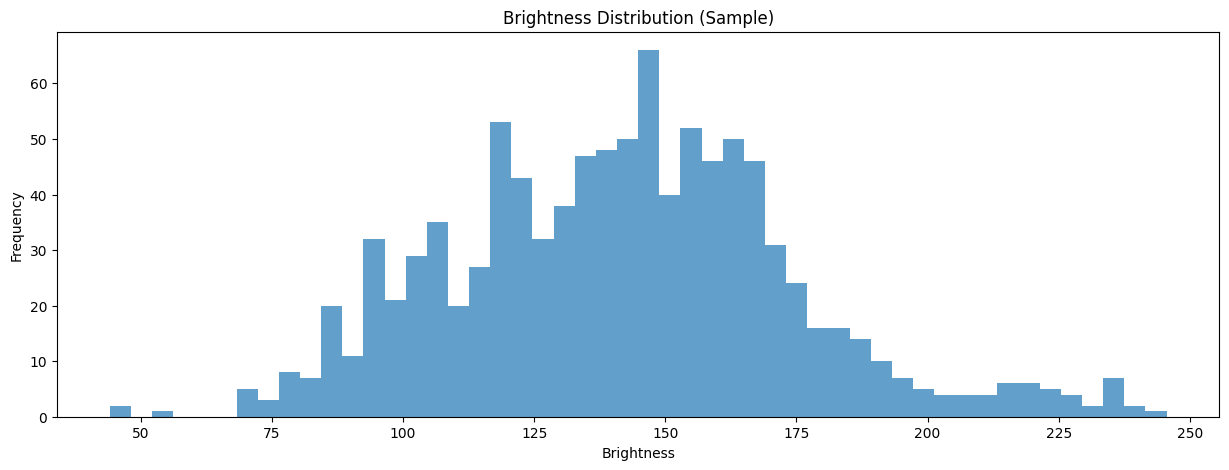

In [26]:
# Sample a random subset of the dataset for brightness analysis
sample_size = 1000
sample_data_indices = np.random.choice(len(data), sample_size, replace=False)
brightness = []

for idx in sample_data_indices:
    img_path = data[idx][0]
    img = Image.open(img_path).convert('L')
    brightness.append(np.mean(np.array(img)))

sample_brightness = pd.DataFrame(brightness, columns=['Brightness'])

# Plot brightness distribution for the sample
plt.figure(figsize=(15, 5))
plt.hist(sample_brightness['Brightness'], bins=50, alpha=0.7)
plt.xlabel('Brightness')
plt.ylabel('Frequency')
plt.title('Brightness Distribution (Sample)')
plt.show()

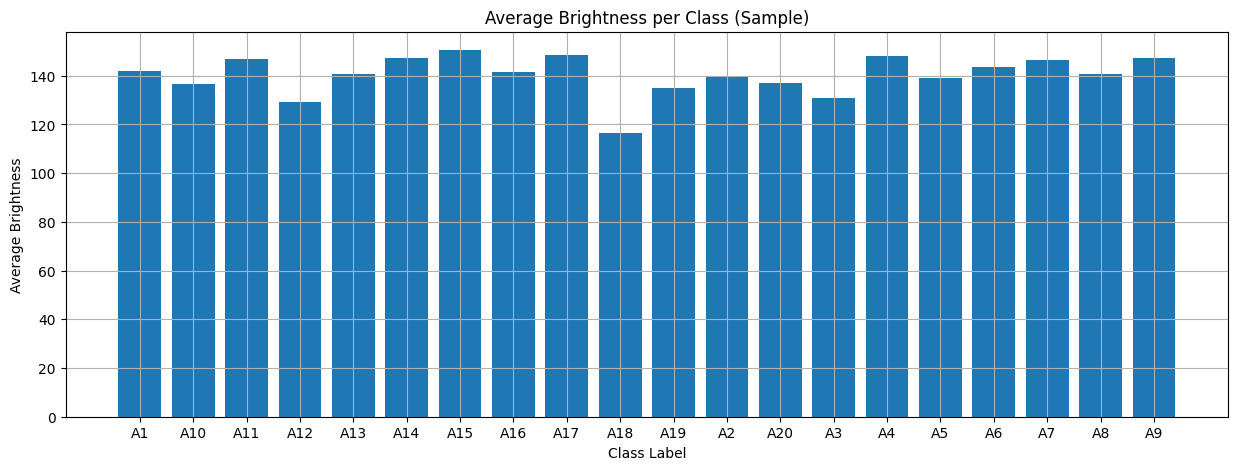

In [27]:
# Brightness distribution per class for the sample
sample_labels = [labels[idx] for idx in sample_data_indices]
brightness_per_class = pd.DataFrame({'ClassId': sample_labels, 'Brightness': brightness}).groupby('ClassId')['Brightness'].mean()

plt.figure(figsize=(15, 5))
plt.bar(brightness_per_class.index, brightness_per_class.values)
plt.xlabel('Class Label')
plt.ylabel('Average Brightness')
plt.title('Average Brightness per Class (Sample)')
plt.grid(True)
plt.show()

I am a bit worried by severely unequal per-class distribution and would like to mitigate the risks of some classes undertraining. At first I decided that simplest pass would be to remove overepresented classes. Lets take maximum of 500 images of each class.

In [28]:
# Counter to count instances of each class
class_counter = Counter(labels)
max_count = 500

def filter_data(data, class_counter, max_count):
    new_data = []
    new_class_counter = {class_name: 0 for class_name in class_counter}
    for img_path, xml_path, dimensions in data:
        annotations = read_annotations(xml_path)
        filtered_annotations = []
        for annot in annotations:
            class_name = annot[0]
            if new_class_counter[class_name] < max_count:
                filtered_annotations.append(annot)
                new_class_counter[class_name] += 1
        if filtered_annotations:
            new_data.append((img_path, xml_path, dimensions))
    return new_data

filtered_data = filter_data(data, class_counter, max_count)

# Update labels based on filtered_data
new_labels = []
for img_path, xml_path, dimensions in filtered_data:
    annotations = read_annotations(xml_path)
    for annot in annotations:
        new_labels.append(annot[0])

# Recount instances of each class in the new dataset
new_class_counter = Counter(new_labels)
sorted_new_class_counter = dict(sorted(new_class_counter.items()))

# Print new statistics
for class_label, count in sorted_new_class_counter.items():
    print(f'Class {class_label}: {count} instances')

Class A1: 678 instances
Class A10: 508 instances
Class A11: 410 instances
Class A12: 507 instances
Class A13: 590 instances
Class A14: 756 instances
Class A15: 473 instances
Class A16: 605 instances
Class A17: 814 instances
Class A18: 125 instances
Class A19: 556 instances
Class A2: 600 instances
Class A20: 508 instances
Class A3: 507 instances
Class A4: 453 instances
Class A5: 511 instances
Class A6: 346 instances
Class A7: 485 instances
Class A8: 506 instances
Class A9: 562 instances


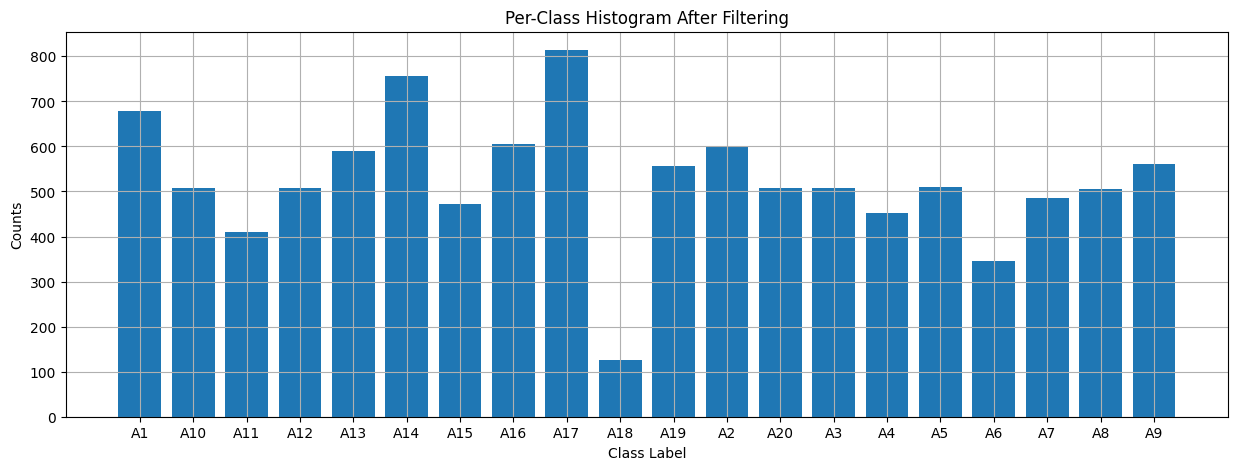

In [29]:
# Plot the updated per-class histogram
plt.figure(figsize=(15, 5))
plt.bar(sorted_new_class_counter.keys(), sorted_new_class_counter.values())
plt.grid(True)
plt.xlabel('Class Label')
plt.ylabel('Counts')
plt.title('Per-Class Histogram After Filtering')
plt.show()

In [32]:
# List of class names in the order of their class IDs
class_names = ['A1', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A2', 'A20', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9']

# Split data into training and validation sets
random.shuffle(data)
split_index = int(0.8 * len(data))
train_data = data[:split_index]
val_data = data[split_index:]

# Ensure paths in train.txt and test.txt are correct
train_files = [os.path.join(data_dir, 'Images', f"{os.path.splitext(os.path.basename(x[0]))[0]}.jpg") for x in train_data]
val_files = [os.path.join(data_dir, 'Images', f"{os.path.splitext(os.path.basename(x[0]))[0]}.jpg") for x in val_data]

# Write paths to image and XML annotation files
def write_data_to_file(data, file_path):
    with open(file_path, 'w') as f:
        for img_path, xml_path, _ in data:
            f.write(f"{img_path}\t{xml_path}\n")

# Use new file names for image-annotation pairs to avoid overwriting
write_data_to_file(train_data, os.path.join(data_dir, 'DataLists', 'train.txt'))
write_data_to_file(val_data, os.path.join(data_dir, 'DataLists', 'test.txt'))

# YOLO

In [33]:
import shutil

# Function to parse XML and convert to YOLO format
def convert_xml_to_yolo(xml_path, img_size=(800, 800)):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    yolo_data = []

    for obj in root.findall('object'):
        name = obj.find('name').text
        class_id = class_names.index(name)

        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        # Convert to YOLO format
        x_center = (xmin + xmax) / 2 / img_size[0]
        y_center = (ymin + ymax) / 2 / img_size[1]
        width = (xmax - xmin) / img_size[0]
        height = (ymax - ymin) / img_size[1]

        yolo_data.append(f"{class_id} {x_center} {y_center} {width} {height}")

    return yolo_data

# Function to copy files based on file path lists and convert labels
def copy_and_convert_files(file_list, img_dest, lbl_dest):
    with open(file_list, 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split('\t')
            if len(parts) != 2:
                print(f"Skipping line due to unexpected format: {line}")
                continue
            img_path, xml_path = parts
            shutil.copy(img_path, img_dest)

            # Convert XML to YOLO and save
            yolo_data = convert_xml_to_yolo(xml_path)
            yolo_lbl_path = os.path.join(lbl_dest, os.path.splitext(os.path.basename(img_path))[0] + '.txt')
            with open(yolo_lbl_path, 'w') as lbl_file:
                lbl_file.write("\n".join(yolo_data))

# Create directories for YOLO dataset
yolo_base_dir = '/content/datasets/dataset'
train_img_dir = os.path.join(yolo_base_dir, 'train/images')
train_lbl_dir = os.path.join(yolo_base_dir, 'train/labels')
val_img_dir = os.path.join(yolo_base_dir, 'val/images')
val_lbl_dir = os.path.join(yolo_base_dir, 'val/labels')

os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(train_lbl_dir, exist_ok=True)
os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(val_lbl_dir, exist_ok=True)

# Copy and convert training and validation files
copy_and_convert_files(os.path.join(data_dir, 'DataLists', 'train.txt'), train_img_dir, train_lbl_dir)
copy_and_convert_files(os.path.join(data_dir, 'DataLists', 'test.txt'), val_img_dir, val_lbl_dir)

In [34]:
# Create data.yaml with correct paths
data_yaml_content = f"""
train: {os.path.join(yolo_base_dir, 'train')}
val: {os.path.join(yolo_base_dir, 'val')}
nc: {len(set(labels))}
names: {list(set(labels))}
"""

with open('data.yaml', 'w') as f:
    f.write(data_yaml_content)

In [35]:
# Train YOLO
yolo_model = YOLO('yolov5su.pt')
yolo_model.train(data='data.yaml', epochs=30, imgsz=800)

# Validate YOLO
yolo_results = yolo_model.val()
print(yolo_results)

100%|██████████| 17.7M/17.7M [00:00<00:00, 55.1MB/s]


Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov5su.pt, data=data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=800, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, lin

100%|██████████| 755k/755k [00:00<00:00, 107MB/s]

Overriding model.yaml nc=80 with nc=20

                   from  n    params  module                                       arguments                     


  0                  -1  1      3520  ultralytics.nn.modules.conv.Conv             [3, 32, 6, 2, 2]              
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     18816  ultralytics.nn.modules.block.C3              [64, 64, 1]                   
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    115712  ultralytics.nn.modules.block.C3              [128, 128, 2]                 
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  3    625152  ultralytics.nn.modules.block.C3              [256, 256, 3]                 
  7                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  8                  -1  1   1182720  ultralytics.nn.modules.block.C3              [512,

100%|██████████| 6.25M/6.25M [00:00<00:00, 351MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/dataset/train/labels... 2533 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2533/2533 [00:01<00:00, 1278.45it/s]


train: New cache created: /content/datasets/dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/datasets/dataset/val/labels... 634 images, 0 backgrounds, 0 corrupt: 100%|██████████| 634/634 [00:00<00:00, 1056.33it/s]


val: New cache created: /content/datasets/dataset/val/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 800 train, 800 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      6.03G      1.274      2.871      1.247         42        800: 100%|██████████| 159/159 [00:43<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  2.91it/s]

                   all        634       3633      0.398      0.538      0.475       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      5.96G      1.032      1.553      1.103         68        800: 100%|██████████| 159/159 [00:37<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.69it/s]

                   all        634       3633      0.665      0.627      0.657      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      5.96G      1.003      1.225      1.088         33        800: 100%|██████████| 159/159 [00:37<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.92it/s]

                   all        634       3633      0.756      0.641      0.725      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      5.93G     0.9826      1.073       1.08         44        800: 100%|██████████| 159/159 [00:37<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.87it/s]

                   all        634       3633      0.821      0.784      0.844      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      5.93G     0.9496     0.9542      1.058         46        800: 100%|██████████| 159/159 [00:37<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.90it/s]

                   all        634       3633      0.835      0.836      0.883      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      5.94G       0.93     0.8595      1.055         48        800: 100%|██████████| 159/159 [00:37<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.91it/s]

                   all        634       3633      0.858      0.836       0.91        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      5.91G     0.9044     0.8167      1.041         19        800: 100%|██████████| 159/159 [00:37<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.87it/s]

                   all        634       3633      0.892      0.816      0.899      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30       5.9G      0.888     0.7545      1.044         32        800: 100%|██████████| 159/159 [00:37<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.91it/s]

                   all        634       3633      0.884      0.883      0.929      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      5.87G     0.8727     0.7025      1.027         40        800: 100%|██████████| 159/159 [00:37<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.95it/s]

                   all        634       3633      0.886      0.893      0.939      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      5.95G     0.8538      0.673      1.022         47        800: 100%|██████████| 159/159 [00:37<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.91it/s]

                   all        634       3633      0.886      0.914      0.942      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      5.96G     0.8476     0.6285       1.02         32        800: 100%|██████████| 159/159 [00:37<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.96it/s]

                   all        634       3633       0.91       0.91      0.949       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      5.94G     0.8398     0.6212      1.023         33        800: 100%|██████████| 159/159 [00:37<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.93it/s]

                   all        634       3633      0.925       0.94       0.97      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      5.88G     0.8322     0.6035      1.014         47        800: 100%|██████████| 159/159 [00:37<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.93it/s]

                   all        634       3633      0.947      0.919      0.965      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      5.97G     0.8148     0.5825      1.004         48        800: 100%|██████████| 159/159 [00:37<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.94it/s]

                   all        634       3633      0.926      0.914      0.956      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      5.93G     0.8062     0.5645      1.001         22        800: 100%|██████████| 159/159 [00:37<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.88it/s]

                   all        634       3633      0.946      0.933      0.972      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      5.92G     0.8001     0.5585     0.9986         24        800: 100%|██████████| 159/159 [00:37<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.93it/s]

                   all        634       3633      0.966      0.929      0.975      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      5.94G     0.7833     0.5346     0.9913         36        800: 100%|██████████| 159/159 [00:37<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.92it/s]

                   all        634       3633      0.962      0.945      0.975      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      5.92G     0.7843     0.5226     0.9919         35        800: 100%|██████████| 159/159 [00:37<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.91it/s]

                   all        634       3633       0.94      0.953      0.972      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      5.92G     0.7713     0.5015     0.9869         17        800: 100%|██████████| 159/159 [00:37<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.93it/s]

                   all        634       3633      0.949      0.941      0.974      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30       5.9G     0.7501     0.4787     0.9779         54        800: 100%|██████████| 159/159 [00:37<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.91it/s]

                   all        634       3633      0.939      0.941      0.967       0.79


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      5.96G     0.7177     0.4344     0.9638         37        800: 100%|██████████| 159/159 [00:39<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.85it/s]

                   all        634       3633      0.942      0.957      0.976      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      5.87G     0.7168     0.4202      0.963         14        800: 100%|██████████| 159/159 [00:36<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.93it/s]

                   all        634       3633      0.972      0.958      0.982      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      5.95G      0.701     0.4095     0.9597         27        800: 100%|██████████| 159/159 [00:36<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.91it/s]

                   all        634       3633      0.948      0.959      0.978       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30       5.9G     0.6934     0.3923     0.9528         19        800: 100%|██████████| 159/159 [00:36<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.96it/s]

                   all        634       3633      0.962       0.96      0.978       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      5.93G      0.686     0.3843     0.9485         27        800: 100%|██████████| 159/159 [00:36<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.85it/s]

                   all        634       3633      0.962      0.956      0.981      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      5.92G     0.6809     0.3696     0.9416         29        800: 100%|██████████| 159/159 [00:36<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.88it/s]

                   all        634       3633       0.97      0.961      0.981      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      5.96G     0.6709     0.3655     0.9394         31        800: 100%|██████████| 159/159 [00:37<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.86it/s]

                   all        634       3633       0.97      0.957      0.985      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      5.91G     0.6627     0.3538     0.9358         21        800: 100%|██████████| 159/159 [00:37<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.81it/s]

                   all        634       3633      0.974      0.953      0.982      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      5.93G     0.6531     0.3441     0.9343         28        800: 100%|██████████| 159/159 [00:37<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.90it/s]

                   all        634       3633      0.977      0.964      0.984      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      5.87G     0.6472     0.3433     0.9288         41        800: 100%|██████████| 159/159 [00:37<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.77it/s]

                   all        634       3633      0.966      0.974      0.984      0.825



30 epochs completed in 0.365 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.73 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLOv5s summary (fused): 193 layers, 9,119,276 parameters, 0 gradients, 23.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]


                   all        634       3633      0.966      0.974      0.984      0.825
                    A6         79        376      0.955      0.992      0.993       0.86
                    A8         28        132      0.993      0.985      0.995       0.81
                   A19         22         42      0.928      0.918      0.956      0.799
                    A2         42        114      0.958      0.939      0.959      0.813
                   A16         47        288      0.934          1      0.992      0.801
                    A7         73        304      0.963      0.997      0.994      0.835
                   A12         15         51      0.903      0.917      0.954      0.761
                   A11         53        429      0.969      0.998      0.992      0.812
                   A20         77        297      0.968       0.99      0.982      0.868
                   A10         10         22      0.999      0.955      0.993      0.861
                    A

val: Scanning /content/datasets/dataset/val/labels.cache... 634 images, 0 backgrounds, 0 corrupt: 100%|██████████| 634/634 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:12<00:00,  3.26it/s]


                   all        634       3633      0.966      0.974      0.984      0.824
                    A6         79        376      0.954      0.992      0.993       0.86
                    A8         28        132      0.993      0.985      0.995      0.807
                   A19         22         42      0.928      0.921      0.956      0.804
                    A2         42        114      0.957      0.939      0.959      0.814
                   A16         47        288      0.934          1      0.992      0.802
                    A7         73        304      0.963      0.997      0.994      0.833
                   A12         15         51      0.904      0.919      0.954      0.755
                   A11         53        429      0.968      0.998      0.992      0.811
                   A20         77        297      0.968       0.99      0.982      0.867
                   A10         10         22      0.997      0.955      0.993      0.857
                    A

# Faster R-CNN

In [40]:
class CustomDataset(Dataset):
    def __init__(self, txt_file, transforms=None):
        self.txt_file = txt_file
        self.transforms = transforms
        self.imgs = []
        self.annotations = []
        with open(txt_file) as f:
            lines = f.readlines()
            for line in lines:
              parts = line.strip().split('\t')
              if len(parts) != 2:
                  print(f"Skipping line due to unexpected format: {line}")
                  continue
            img_path, xml_path = parts
            self.imgs.append(img_path)
            self.annotations.append(xml_path)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        xml_path = self.annotations[idx]
        img = Image.open(img_path).convert("RGB")
        target = self.parse_xml(xml_path)

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

    def parse_xml(self, xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()
        boxes = []
        labels = []
        for obj in root.findall('object'):
            name = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(class_names.index(name) + 1)  # class label starts from 1

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return target

In [41]:
transforms = T.Compose([T.ToTensor()])

train_dataset = CustomDataset(os.path.join(data_dir, 'DataLists', 'train.txt'), transforms)
val_dataset = CustomDataset(os.path.join(data_dir, 'DataLists', 'test.txt'), transforms)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [43]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Define the model
model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = len(class_names) + 1  # number of classes + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    for images, targets in train_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {losses.item()}')

# Validation
model.eval()
with torch.no_grad():
    for images, targets in val_loader:
        images = list(img.to(device) for img in images)
        outputs = model(images)
        print(outputs)

Epoch 1, Loss: 4.469553470611572
Epoch 2, Loss: 9.805203437805176
Epoch 3, Loss: 12.007905006408691
Epoch 4, Loss: 0.7610428929328918
Epoch 5, Loss: 2.55226993560791
Epoch 6, Loss: 1.1764764785766602
Epoch 7, Loss: 0.7405446767807007
Epoch 8, Loss: 3.077796459197998
Epoch 9, Loss: 22.408409118652344
Epoch 10, Loss: 1.3768590688705444
Epoch 11, Loss: 2.4345743656158447
Epoch 12, Loss: 1.2696669101715088
Epoch 13, Loss: 1.363203763961792
Epoch 14, Loss: 1.1324294805526733
Epoch 15, Loss: 1.1516495943069458
Epoch 16, Loss: 1.1374608278274536
Epoch 17, Loss: 0.9813761711120605
Epoch 18, Loss: 0.9723103046417236
Epoch 19, Loss: 0.6948862075805664
Epoch 20, Loss: 0.8476690053939819
Epoch 21, Loss: 0.8126424551010132
Epoch 22, Loss: 0.9672707319259644
Epoch 23, Loss: 0.8799107670783997
Epoch 24, Loss: 1.0394307374954224
Epoch 25, Loss: 0.8621476888656616
Epoch 26, Loss: 0.642608106136322
Epoch 27, Loss: 0.6982955932617188
Epoch 28, Loss: 0.7234872579574585
Epoch 29, Loss: 0.9950163960456848
E

# RetinaNet

In [49]:
from torchvision.models.detection import RetinaNet_ResNet50_FPN_Weights, retinanet_resnet50_fpn
from torchvision.models.detection.retinanet import RetinaNetHead

# Load the pre-trained RetinaNet model
retinanet_model = retinanet_resnet50_fpn(weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT)
num_classes = len(set(labels)) + 1  # +1 for background

# Modify the classification head
in_features = retinanet_model.head.classification_head.conv[0][0].in_channels
num_anchors = retinanet_model.head.classification_head.num_anchors
retinanet_model.head.classification_head = RetinaNetHead(in_features, num_anchors, num_classes)

retinanet_model.to(device)

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


In [50]:
# Define the optimizer
optimizer = torch.optim.Adam(retinanet_model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    retinanet_model.train()
    epoch_loss = 0
    for images, targets in train_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = retinanet_model(images, targets)

        # Sum up all the losses
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass and optimization
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    print(f'Epoch {epoch + 1}, Loss: {epoch_loss / len(train_loader)}')

# Validation
retinanet_model.eval()
with torch.no_grad():
    for images, targets in val_loader:
        images = list(img.to(device) for img in images)
        outputs = retinanet_model(images)
        print(outputs)

TypeError: RetinaNetHead.compute_loss() missing 1 required positional argument: 'matched_idxs'

# EfficientDet

In [59]:

!pip install pyyaml==5.1
!pip install git+https://github.com/facebookresearch/fvcore.git
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu113/torch1.10/index.html

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

In [ ]:
train_dataset = CustomDataset('/path/to/train.txt')
val_dataset = CustomDataset('/path/to/val.txt')

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
effdet_model = create_model('tf_efficientdet_d0', num_classes=len(class_names) + 1, pretrained=True)
effdet_model = DetBenchTrain(effdet_model, config=effdet_model.config)
effdet_model.to(device)
optimizer = torch.optim.AdamW(effdet_model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    effdet_model.train()
    epoch_loss = 0
    for images, targets in train_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = effdet_model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()

    print(f'Epoch {epoch + 1}, Loss: {epoch_loss / len(train_loader)}')

In [ ]:
effdet_model.eval()
with torch.no_grad():
    for images, targets in val_loader:
        images = list(img.to(device) for img in images)
        outputs = effdet_model(images)
        print(outputs)

Evaluation of the models

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score

# Placeholder for storing evaluation results
evaluation_results = {}

# Function to evaluate a model
def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    precision = precision_score(y_val, y_pred, average='macro')
    recall = recall_score(y_val, y_pred, average='macro')
    f1 = f1_score(y_val, y_pred, average='macro')
    mAP = average_precision_score(y_val, y_pred, average='macro')
    return precision, recall, f1, mAP

# Evaluate CNN model
precision, recall, f1, mAP = evaluate_model(cnn_model, X_val, y_val)
evaluation_results['CNN'] = (precision, recall, f1, mAP)

# Evaluate YOLO model
# Similar code for YOLO, Faster R-CNN, RetinaNet, and EfficientDet

Inference Time

In [ ]:
import time

# Function to measure inference time
def measure_inference_time(model, X_val):
    start_time = time.time()
    model.predict(X_val)
    end_time = time.time()
    inference_time = end_time - start_time
    return inference_time

# Measure inference time for CNN model
inference_time_cnn = measure_inference_time(cnn_model, X_val)
evaluation_results['CNN'] += (inference_time_cnn,)

# Measure inference time for YOLO model
# Similar code for YOLO, Faster R-CNN, RetinaNet, and EfficientDet

Conclusion

1. Good data is a key! Garbge in - garbage out
2. Basic CNN would not work for object detection and clasification, vasted time on that track